In [296]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials
using SciMLBase
using QuadGK

In [297]:
outdict = readinput("Ag_C2_042925.rms")

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [298]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [299]:
sitedensity = 2.294e-5; # Ag111 site density is 2.294e-9 mol/cm^2 or 2.294e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [300]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2 * 1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.943e-5 mol/m^2 * 3.6e-3 m^2 = 10.595e-8 mol

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 1e3;
layer_thickness = 1e-3;
A_surf = V_res*36;
# V_bl = A_surf*layer_thickness;
V_bl = V_res;
sites = sitedensity*A_surf;

# The initial conditions for individual species are moles not concentration, so we need to multiply concentration by boundary layer volume
initialcondsboundarylayer = Dict(["proton"=>C_proton*V_bl,
                                  "CO2"=>C_co2*V_bl,
                                  "H2"=>C_default*10*V_bl,
                                  "O=CO"=>C_default*V_bl,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -1.0 V vs. R.H.E. which equates to -1.414 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        # "CHO2X"=>0.1*sites,
        # "CO2HX"=>0.1*sites,
        # "OX"=>0.1*sites,
        # "OCX"=>0.1*sites,
        "vacantX"=>0.6*sites,
        # "CH2O2X"=>0.05*sites,
        # "CHOX"=>0.04*sites,
        # "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [301]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [302]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [303]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, layer_thickness);

In [304]:
interfaces = [inter, diffusionlayer];

In [305]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

In [ ]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-22,reltol=1e-8);
println(sol.t[end]);
println(sol.retcode);

In [309]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [310]:
concentrations(ssys.sims[1], 1e3)

25-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 10.0
  9.999999999999999e-5
  0.0
  0.0
  9.62191195180568e-13
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [311]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    # println(reservoirinterface.A);
    # println(reservoirinterface.layer_thickness);
    # println(sim.domain.diffusivity);
    # println(cs);
    # println(reservoirinterface.c);
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t);
    return intg./Vres
end

get_reservoir_concentration

In [312]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=100);

# Compute reservoir concentrations
flux_vals = [flux_to_reservoir(ssys.sims[1], t, diffusionlayer) for t in t_vals]
conc_vals = [get_reservoir_concentration(ssys.sims[1], t, diffusionlayer, V_res) for t in t_vals]
conc_vals_bl = [concentrations(ssys.sims[1], t) for t in t_vals]
flux_matrix = hcat(flux_vals...);
conc_matrix = hcat(conc_vals...);
conc_matrix_bl = hcat(conc_vals_bl...);


In [313]:
flux_matrix

25×100 Matrix{Float64}:
  0.0           0.0          0.0          …  0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
 -8.09257e-22  -8.09257e-22  0.0          …  0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  3.85421e-14   3.85421e-14  3.85421e-14     3.75082e-14  3.70849e-14
  0.0           0.0          0.0             0.0          0.0
  ⋮                                       ⋱               
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0             0.0          0.0
  0.0           0.0          0.0         

In [314]:
conc_matrix_bl

25×100 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …   0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
 10.0      10.0      10.0      10.0         10.0          10.0
  0.0001    0.0001    0.0001    0.0001   …   0.0001        0.0001
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  1.0e-12   1.0e-12   1.0e-12   1.0e-12      9.73176e-13   9.62191e-13
  0.0       0.0       0.0       0.0          0.0           0.0
  ⋮                                      ⋱                
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.0       0.0          0.0           0.0
  0.0       0.0       0.

In [315]:
# clf()

# for i in 1:size(conc_matrix, 1)
#     if maximum(conc_matrix[i, :]) > 1e-12
#         plot(t_vals, conc_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

#     end
# end

# xscale("log")
# yscale("log")
# xlabel("Time (s)")
# ylabel("Reservoir Concentration")
# legend()
# tight_layout()
# gcf()

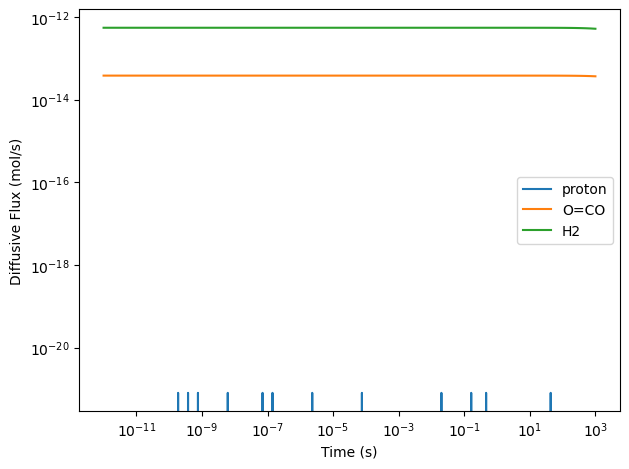

In [316]:
clf()

for i in 1:size(flux_matrix, 1)
    if maximum(flux_matrix[i, :]) > 1e-25
        plot(t_vals, flux_matrix[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Diffusive Flux (mol/s)")
legend()
tight_layout()
gcf()

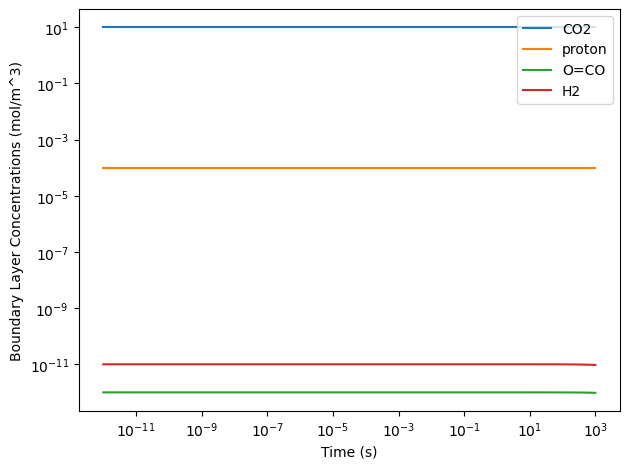

In [317]:
clf()
for i in 1:size(conc_matrix_bl, 1)
    if maximum(conc_matrix_bl[i, :]) > 1e-25
        plot(t_vals, conc_matrix_bl[i, :], label=ssys.sims[1].domain.phase.species[i].name)

    end
end

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Boundary Layer Concentrations (mol/m^3)")
legend()
tight_layout()
gcf()

In [318]:
flux_to_reservoir(ssys.sims[1],1e-12,diffusionlayer)

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.854210047533713e-14
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [319]:
res_cs = get_reservoir_concentration(ssys.sims[1],1e3,diffusionlayer,V_res)

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 3.801243064556776e-23
 0.0
 0.0
 3.780880481959647e-14
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [320]:
sort(res_cs)

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.801243064556776e-23
 3.780880481959647e-14
 5.39681657543837e-13

In [321]:
getfield.(ssys.sims[1].domain.phase.species,:name)

25-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "O2"
 ⋮
 "O=CC=O"
 "O=CCO"
 "COC=O"
 "CC(=O)O"
 "CO-2"
 "CC=O"
 "OCO"
 "OCCO"
 "C=C"

In [322]:
getfield.(ssys.sims[2].domain.phase.species,:name)

76-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "CC#[Pt]"
 "[Pt]C#CO[Pt]"
 "[Pt]OC#CO[Pt]"
 "COC=O.[Pt]"
 "O=COC[Pt]"
 "O=COC=[Pt]"
 "O=COC#[Pt]"
 "[Pt]C=C=[Pt]"
 "[Pt]=CC=[Pt]"

In [323]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [324]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

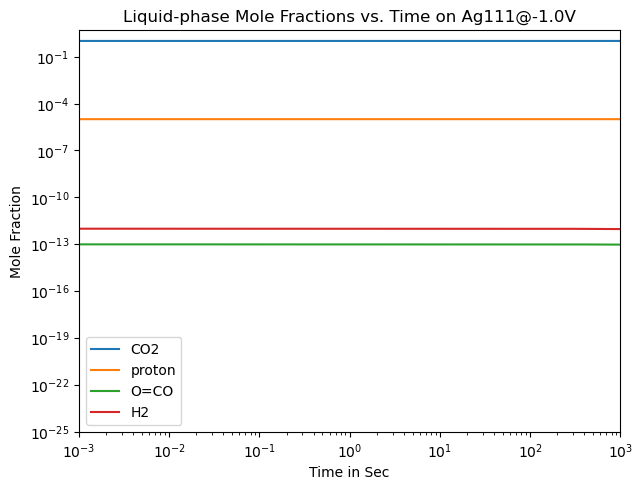

In [325]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-25, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-3, 1e3)
ylim(1e-25, 5)
title("Liquid-phase Mole Fractions vs. Time on Ag111@-1.0V")
gcf()

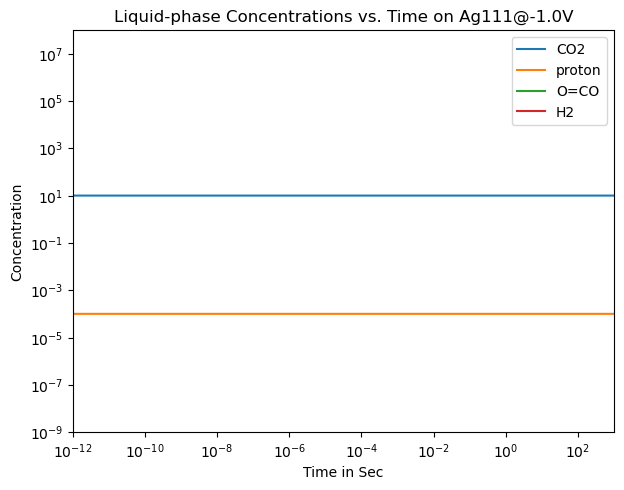

In [326]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-25, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-9, 1e8)
title("Liquid-phase Concentrations vs. Time on Ag111@-1.0V")
gcf()

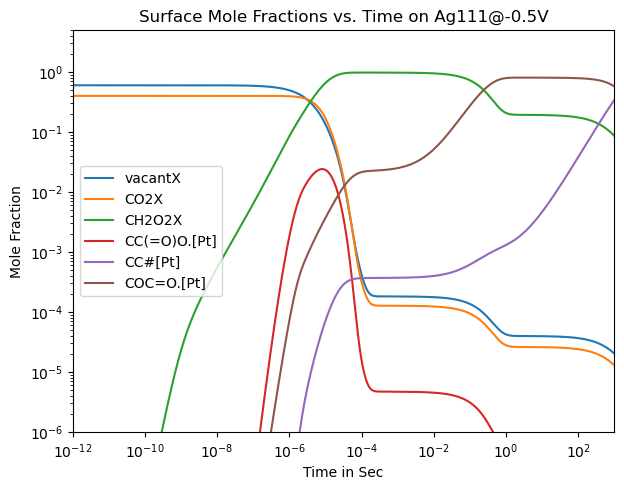

In [327]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

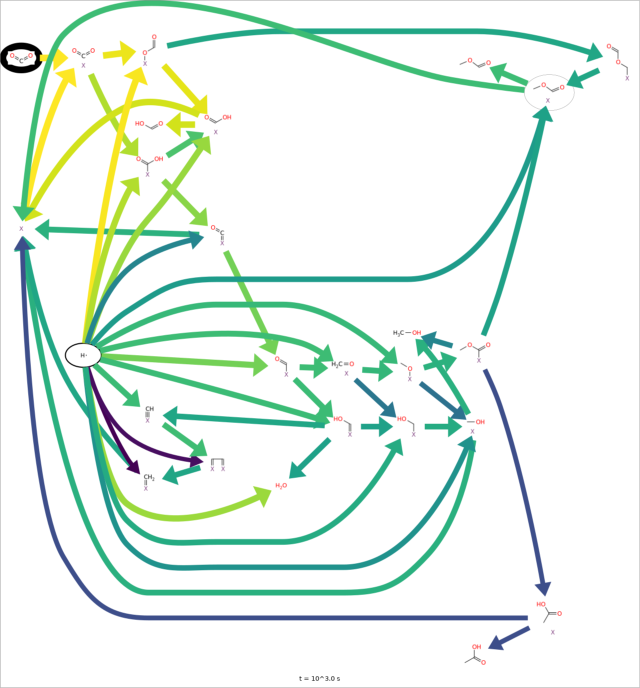

In [328]:
getfluxdiagram(ssys,1e3;speciesratetolerance=1e-8)

In [329]:
function plotROP(ssys,name,t;N=0,tol=0.01)
    clf()
    rop = rops(ssys, name, t)
    inds = rop.nzind[reverse(sortperm(abs.(rop.nzval)))]
    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(rop[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(rop[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    net_rops = sum(rop[inds])
    println("Net ROPs for species $name is: $net_rops")

    for (i, j) in enumerate(inds)
        println("Showing the reaction with $i th highest ROP for species $name:")
        println(getrxnstr(ssys.reactions[j]))
        println("ROP = ", rop[inds[i]])
        println(ssys.reactions[j].kinetics)
    end

    xs = Array{Float64,1}(1:length(inds))
    barh(xs,reverse(rop[inds]))
    yticks(xs,reverse(getrxnstr.(ssys.reactions[inds])))
    xlabel("Production/Loss Rate mol/s")
    gcf()
end

plotROP (generic function with 1 method)

In [330]:
function PrintKinDetail(inter, speciesname)
    println("Showing Kinetics details for reactions involving species $speciesname\n")
    for (i,rxn) in enumerate(inter.reactions)
        flag = false
        for j = 1:length(rxn.reactants)
            if rxn.reactants[j].name == speciesname
                flag = true
            end
        end
        for j = 1:length(rxn.products)
            if rxn.products[j].name == speciesname
                flag = true
            end
        end
        if flag
            println(getrxnstr(rxn))
            println(rxn.kinetics)
            kf = inter.kfs[i]
            krev = inter.krevs[i]
            kc = kf/krev
            println("kf = $kf")
            println("krev = $krev")
            println("Kc = $kc\n")
        end
    end
end

PrintKinDetail (generic function with 1 method)

In [331]:
"""
Integrates the ROP in the boundary layer and computes the concentration
"""
function get_boundary_layer_concentration(sim,t,spc,Vbl,C_0)
    intg,err = quadgk(x -> sum(rops(sim,spc,t)), 0, t);
    return C_0 + intg ./ Vbl;
end

get_boundary_layer_concentration

In [332]:
"""
diffusive flux to the reservoir using concentration from ROP integration
"""
function flux_to_reservoir_2(bsol,t,spc,Vbl,C_0,reservoirinterface)
    cs = get_boundary_layer_concentration(bsol,t,spc,Vbl,C_0)
    spc_idx = findfirst(s -> s.name == spc, bsol.sims[1].species)
    d = bsol.sims[1].domain.diffusivity[spc_idx];
    c_res = reservoirinterface.c[spc_idx];
    # println(reservoirinterface.A);
    # println(reservoirinterface.layer_thickness);
    # println(sim.domain.diffusivity);
    # println(cs);
    # println(reservoirinterface.c);
    return reservoirinterface.A * d * (cs - c_res) / reservoirinterface.layer_thickness
end

flux_to_reservoir_2

In [ ]:
# Logarithmic time scale
t_vals = 10 .^ range(-12, stop=3, length=1000);

# Compute ROP over time
ROP_vals = [sum(rops(ssys, "O=CO", t)) for t in t_vals];
# Compute boundary layer accumulation by integration
Cbl_vals = [get_boundary_layer_concentration(ssys, t, "O=CO", V_bl, C_default) for t in t_vals];
# Compute flux over time using Cbl_vals
F_vals = [flux_to_reservoir_2(ssys, t, "O=CO", V_bl, C_default, diffusionlayer) for t in t_vals];

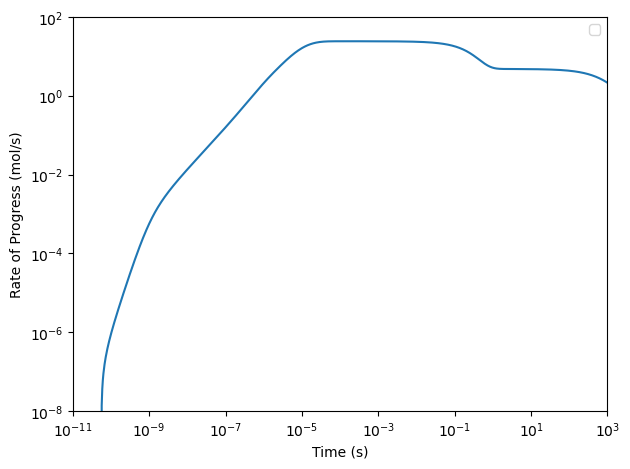

In [335]:
# Plots the ROP of O=CO
clf()

plot(t_vals, ROP_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-8,1e2)
xlabel("Time (s)")
ylabel("Rate of Progress (mol/s)")
legend()
tight_layout()
gcf()

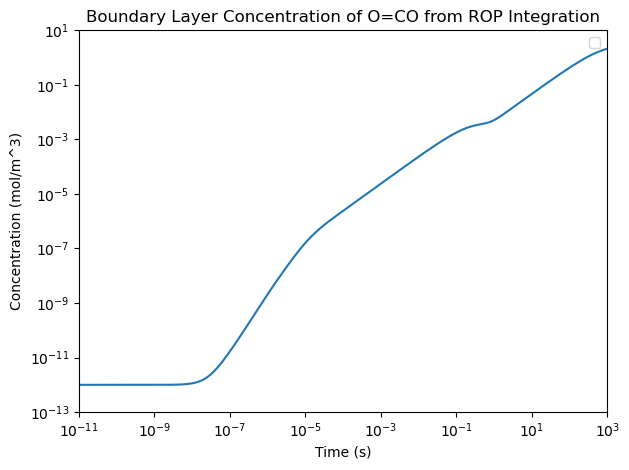

In [ ]:
# Plots the Boundary Layer Concentration of O=CO from ROP Integration WITHOUT Diffusion Flux Into Reservoir
clf()

plot(t_vals, Cbl_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-13,1e1)
xlabel("Time (s)")
ylabel("Concentration (mol/m^3)")
title("Boundary Layer Accumulation of O=CO from ROP Integration")
legend()
tight_layout()
gcf()

In [ ]:
# Plots the Diffusive Flux of O=CO using ROP Integration
clf()

plot(t_vals, Cbl_vals)

xscale("log")
xlim(1e-11,1e3)
yscale("log")
ylim(1e-13,1e1)
xlabel("Time (s)")
ylabel("Concentration (mol/m^3)")
title("Boundary Layer Accumulation of O=CO from ROP Integration")
legend()
tight_layout()
gcf()

In [337]:
rops(ssys,"O=CO",1)

1507-element SparseArrays.SparseVector{Float64, Int64} with 13 stored entries:
  [1329]  =  5.10841
  [1330]  =  1.97646e-18
  [1334]  =  1.9746e-20
  [1335]  =  8.85497e-25
  [1382]  =  3.87874e-16
  [1429]  =  1.09704e-9
  [1466]  =  2.47045e-9
  [1476]  =  9.986e-32
  [1480]  =  2.32947e-21
  [1482]  =  -5.74004e-42
  [1495]  =  3.11354e-7
  [1498]  =  8.59283e-21
  [1500]  =  5.14434e-30

In [338]:
fieldnames(typeof(ssys))

(:sol, :sims, :interfaces, :names, :species, :reactions, :p)

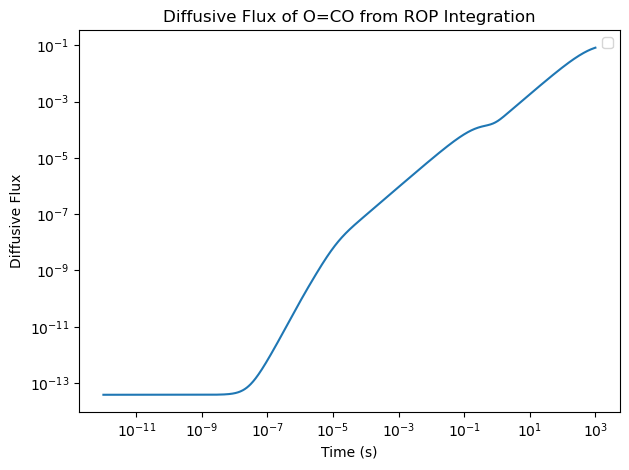

In [339]:
# Plots the Diffusion Flux Into Reservoir Using Integrated Concentration from ROP Analysis
clf()

plot(t_vals, F_vals)

xscale("log")
yscale("log")
xlabel("Time (s)")
ylabel("Diffusive Flux")
title("Diffusive Flux of O=CO from ROP Integration")
legend()
tight_layout()
gcf()

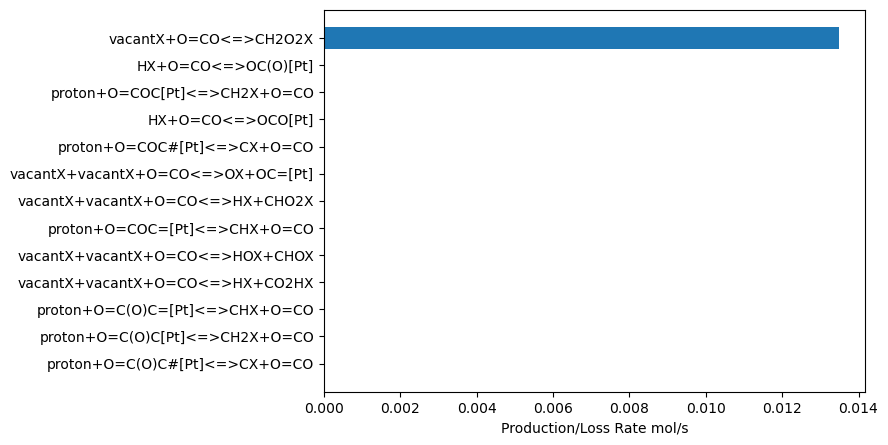

In [340]:
plotROP(ssys, "O=CO",1e-8;N=15,tol=0.0)

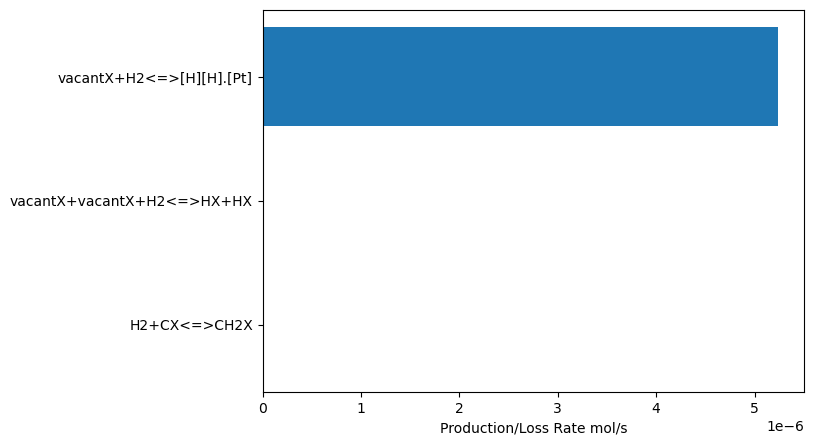

In [341]:
plotROP(ssys, "H2",1;N=15,tol=0.0)

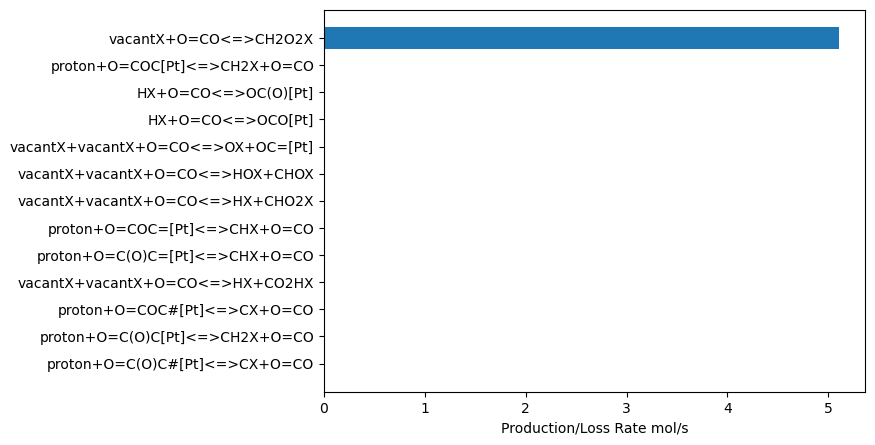

In [342]:
plotROP(ssys, "O=CO",1;N=15,tol=0.0)

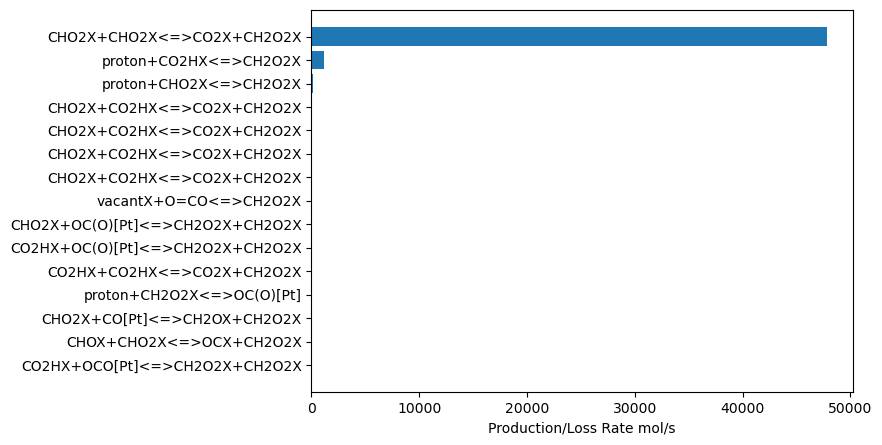

In [343]:
plotROP(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

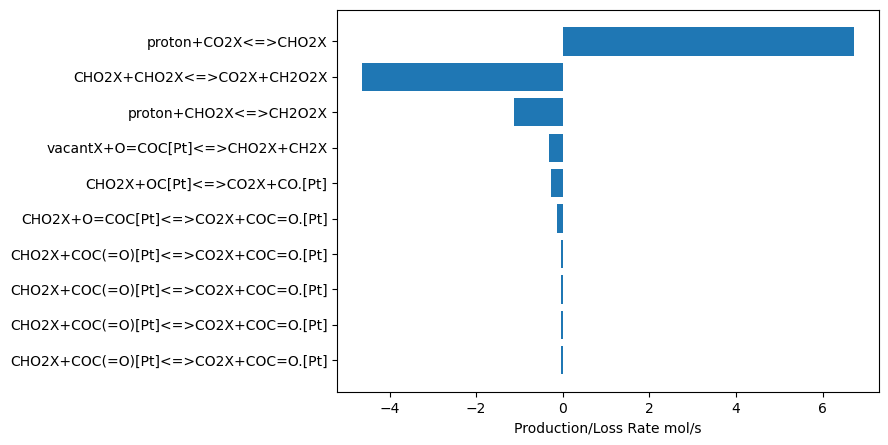

In [344]:
plotROP(ssys,"CHO2X",1;N=10,tol=0.0)

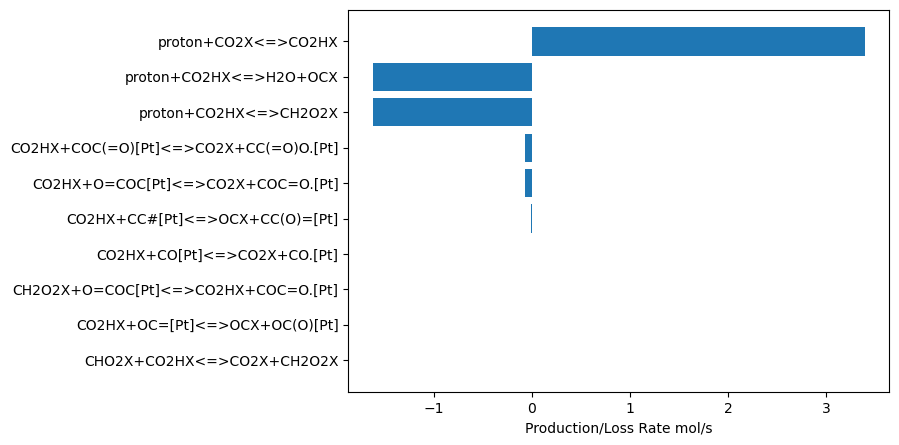

In [345]:
plotROP(ssys,"CO2HX",1;N=10,tol=0.0)

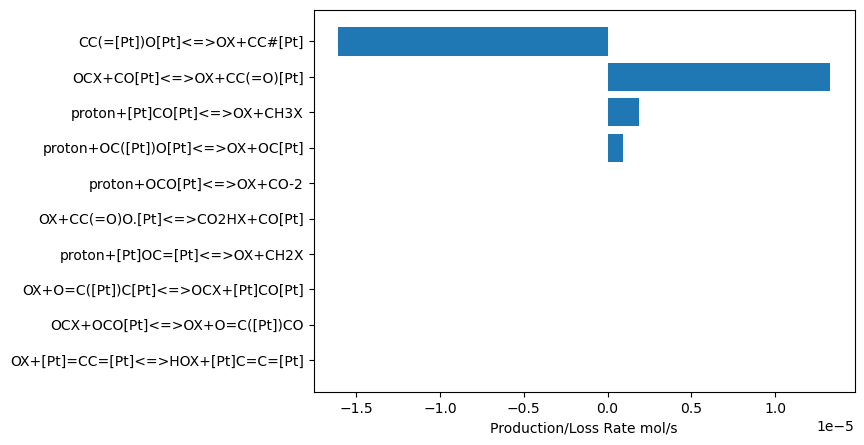

In [346]:
plotROP(ssys,"OX",1;N=10,tol=0.0)

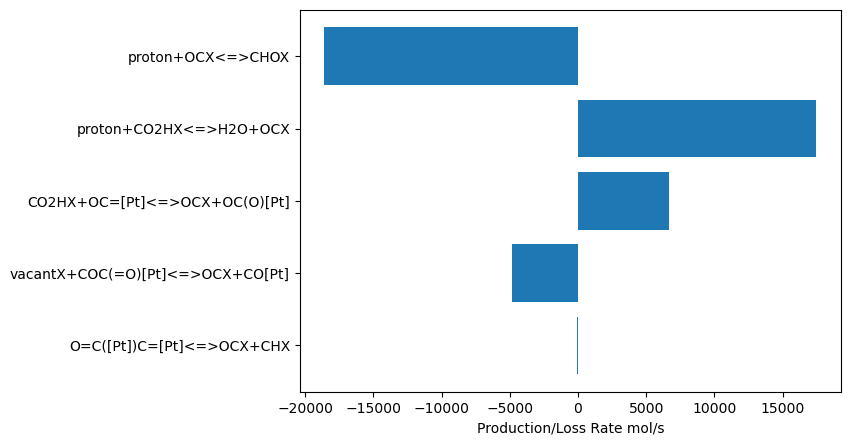

In [347]:
plotROP(ssys,"OCX",1.0e-6)

In [349]:
concentrations(ssys,"O=CO",1)

9.999614586422755e-13

In [353]:
ssys.sol.u[end]

101-element Vector{Float64}:
     0.0
     0.0
     0.0
     0.0
 10000.0
     0.09999999999999999
     0.0
     0.0
     9.62191195180568e-10
     0.0
     ⋮
     0.27810543057964543
     3.3670498793299027e-22
     1.7410340488845516e-23
     0.4761341364037305
     2.9068195312598338e-8
     1.958968329366363e-24
     1.5580238386479222e-35
     2.0900524013824303e-9
     2.783022628518315e-6